In [25]:
import gspread
import pandas as pd
import re
from gspread_dataframe import get_as_dataframe
from collections import defaultdict
import time
import matplotlib.pyplot as plt

In [26]:
CREDENTIALS_JSON = '../rm4mt-463314-3ce1280ee29c.json'
sheet_urls = [
    "https://docs.google.com/spreadsheets/d/1yhLFAwm-sFAG2cDxDBQ6C0smcM_f5uQxYuy_clvgueM/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/19sowSDpBO42OSXFeBM92UBp1H2MZkQQWzEAPMpZz9q4/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/16nVSzWScuuYThX2ZgQAyZ0V5ip5d1GFPKCABjG6IHf8/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/1k_zR5v7em_iz1J3K6p4qRYvFrzbFDOjI8lLWtPK3YCM/edit?usp=sharing",
]
sheet_urls_wait = [
    "https://docs.google.com/spreadsheets/d/1LHsMMvKhTEgagmZKQl7ax1H4BJyDBImYMbeE8sNPjJw/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/1PRIfwNA4l2TG3oMFlgM8LIGuxvCH8prfgEvbGMDhqIY/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/11WAU3v3uKN1wV3G7crmGDyo3u4QX4aGlhWpQN7tn9As/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/1pSBxhdqGvu2I5z_8C6l6pePV-IkIl31MM83Py_ILRqU/edit?usp=sharing",
]

In [27]:
gc = gspread.service_account(filename=CREDENTIALS_JSON)
all_data = {}
all_data_wait = {}

In [28]:
for sheet_url in sheet_urls:
    print(f"Reading Sheet: {sheet_url}")
    spreadsheet = gc.open_by_url(sheet_url)
    ws_data = {}
    for worksheet in spreadsheet.worksheets():
        # print(f"  Worksheet: {worksheet.title}")
        df = get_as_dataframe(worksheet, evaluate_formulas=True)
        df = df.dropna(how='all').dropna(axis=1, how='all')
        ws_data[worksheet.title] = df
        time.sleep(2)
    all_data[sheet_url] = ws_data

for sheet_url in sheet_urls_wait:
    print(f"Reading Sheet: {sheet_url}")
    spreadsheet = gc.open_by_url(sheet_url)
    ws_data = {}
    for worksheet in spreadsheet.worksheets():
        # print(f"  Worksheet: {worksheet.title}")
        df = get_as_dataframe(worksheet, evaluate_formulas=True)
        df = df.dropna(how='all').dropna(axis=1, how='all')
        ws_data[worksheet.title] = df
        time.sleep(2)
    all_data_wait[sheet_url] = ws_data

Reading Sheet: https://docs.google.com/spreadsheets/d/1yhLFAwm-sFAG2cDxDBQ6C0smcM_f5uQxYuy_clvgueM/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/19sowSDpBO42OSXFeBM92UBp1H2MZkQQWzEAPMpZz9q4/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/16nVSzWScuuYThX2ZgQAyZ0V5ip5d1GFPKCABjG6IHf8/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/1k_zR5v7em_iz1J3K6p4qRYvFrzbFDOjI8lLWtPK3YCM/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/1LHsMMvKhTEgagmZKQl7ax1H4BJyDBImYMbeE8sNPjJw/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/1PRIfwNA4l2TG3oMFlgM8LIGuxvCH8prfgEvbGMDhqIY/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/11WAU3v3uKN1wV3G7crmGDyo3u4QX4aGlhWpQN7tn9As/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/1pSBxhdqGvu2I5z_8C6l6pePV-IkIl31MM83Py_ILRqU/edit?usp=sharing


In [29]:
def split_by_metric(all_data):
    dfs_by_metric = defaultdict(list)  # metric: list of rows

    for sheet_url, ws_dict in all_data.items():
        for ws_name, df in ws_dict.items():
            match = re.match(r'(.+?)_((comet_score|comet_kiwi_score|grb|grf|gea_100|gea_5|thinking_length))$', ws_name)
            if not match:
                continue
            task = match.group(1)
            metric = match.group(2)
            # Check must have model & lang_pair
            if not {'model', 'lang_pair'}.issubset(df.columns):
                continue
            # Budget Column
            budget_cols = [col for col in df.columns if isinstance(col, (int, float)) or (isinstance(col, str) and col.isdigit())]
            budget_cols = sorted(budget_cols, key=lambda x: int(x))
            for _, row in df.iterrows():
                model = row['model']
                lang_pair = row['lang_pair']
                for budget in budget_cols:
                    val = row[budget]
                    if pd.isna(val):
                        continue
                    dfs_by_metric[metric].append({
                        'model': model,
                        'task': task,
                        'metric': metric,
                        'lang_pair': lang_pair,
                        'budget': int(budget),
                        'score': float(val)
                    })

    # To DataFrame
    for metric in dfs_by_metric:
        dfs_by_metric[metric] = pd.DataFrame(dfs_by_metric[metric])

    return dfs_by_metric

dfs_by_metric = split_by_metric(all_data)
dfs_by_metric_wait = split_by_metric(all_data_wait )

In [30]:
print("Available Metrics:")
print(list(dfs_by_metric.keys()))

Available Metrics:
['comet_score', 'comet_kiwi_score', 'grb', 'grf', 'gea_100', 'gea_5', 'thinking_length']


In [31]:
dfs_by_metric['comet_score']

,model,task,metric,lang_pair,budget,score
0,Qwen3-0.6B,WMT23-Biomedical-Doc,comet_score,Avg,0,0.777628
1,Qwen3-0.6B,WMT23-Biomedical-Doc,comet_score,Avg,100,0.775402
2,Qwen3-0.6B,WMT23-Biomedical-Doc,comet_score,Avg,200,0.775771
3,Qwen3-0.6B,WMT23-Biomedical-Doc,comet_score,Avg,300,0.775590
4,Qwen3-0.6B,WMT23-Biomedical-Doc,comet_score,Avg,400,0.776870
...,...,...,...,...,...,...
3176,Qwen3-8B,CAMT,comet_score,en-zh,300,0.790817
3177,Qwen3-8B,CAMT,comet_score,en-zh,400,0.790768
3178,Qwen3-8B,CAMT,comet_score,en-zh,500,0.789086
3179,Qwen3-8B,CAMT,comet_score,en-zh,1000,0.791702


In [32]:
def get_model_size(model_name):
    """将模型名中的参数量字符串（如0.6B、13B）转成 float，便于排序"""
    m = re.search(r"(\d+(\.\d+)?)B", model_name)
    if m:
        return float(m.group(1))
    return float("inf")  # 若无B则排最后

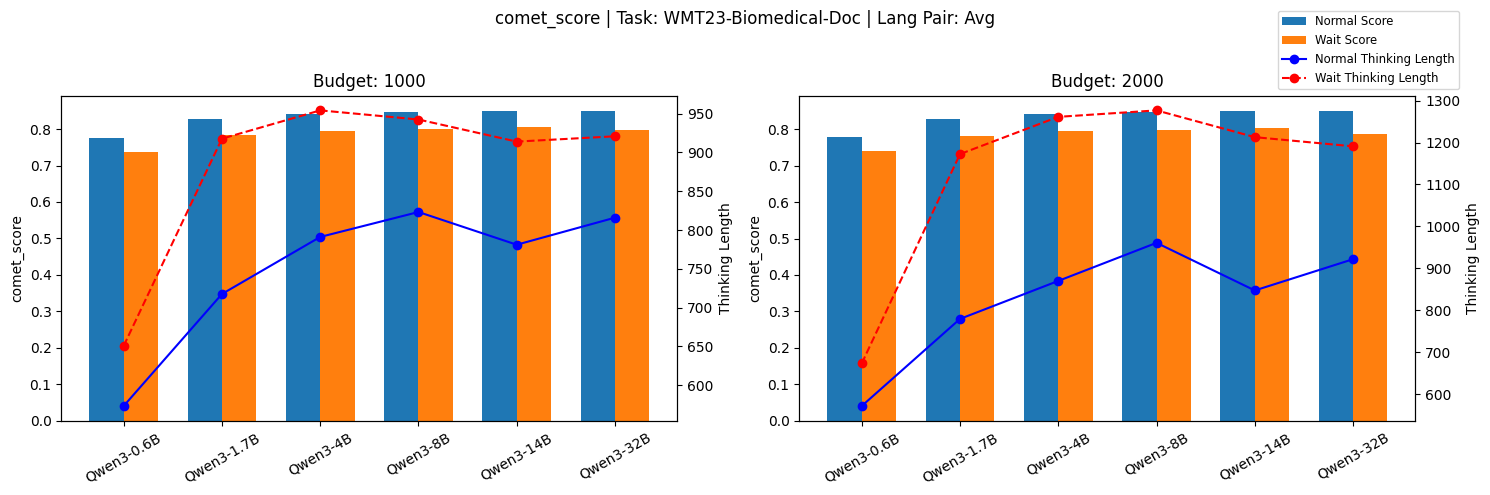

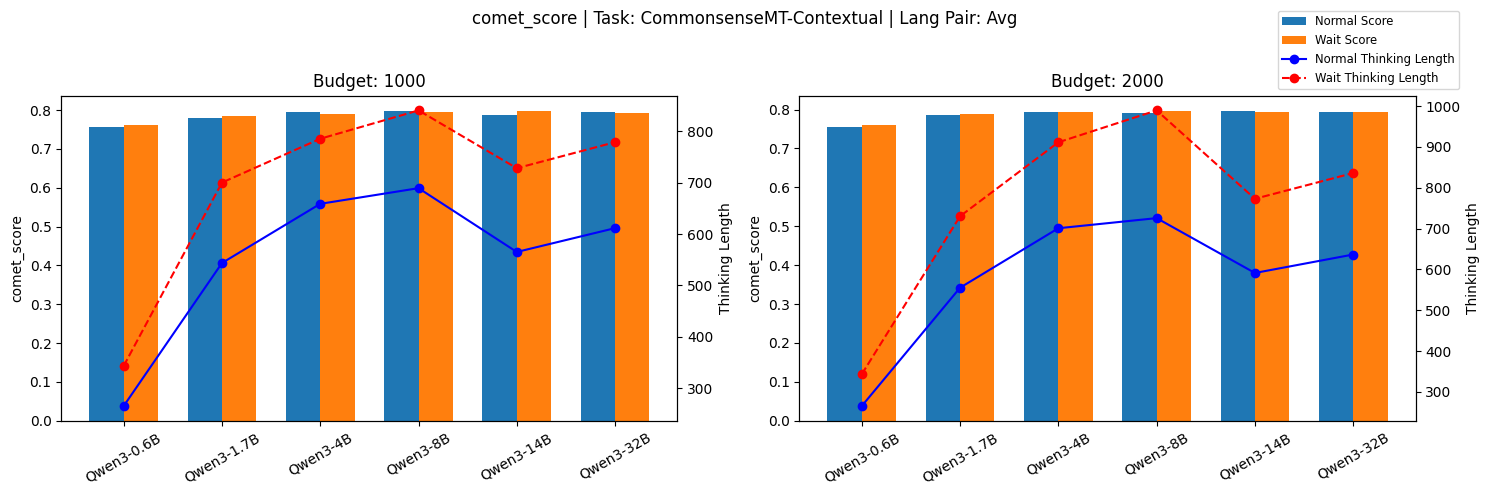

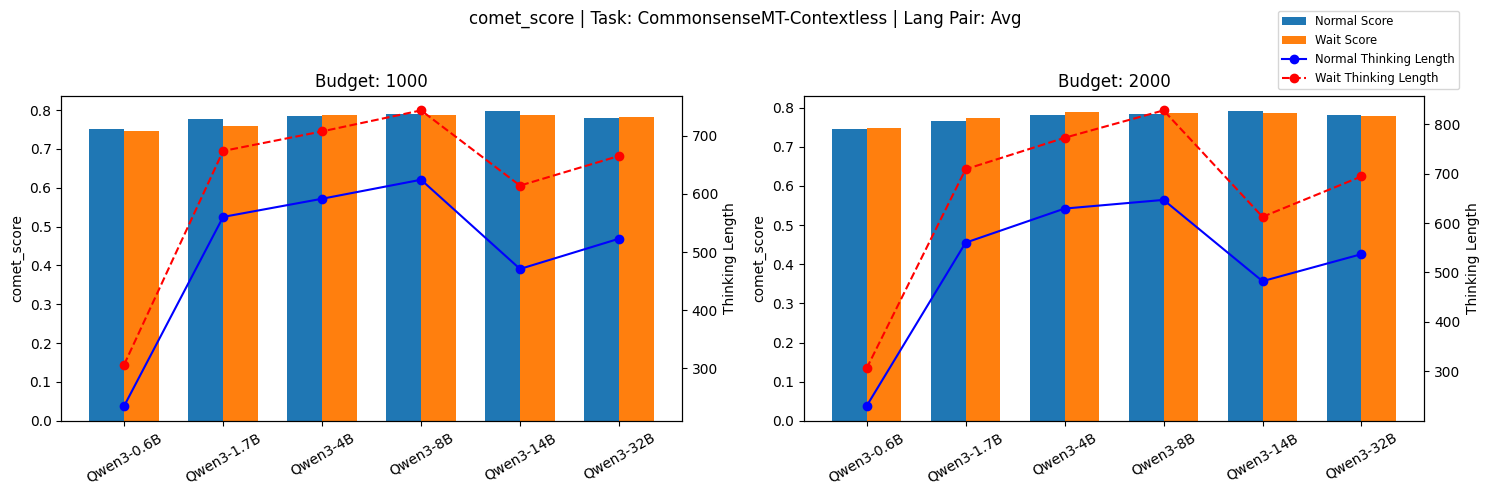

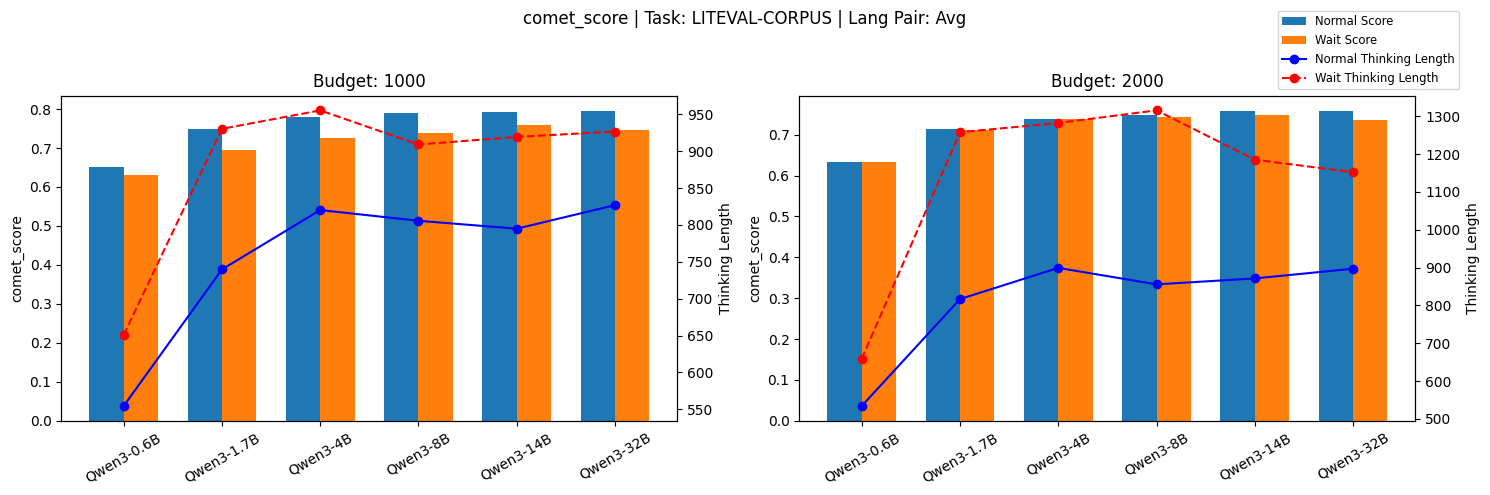

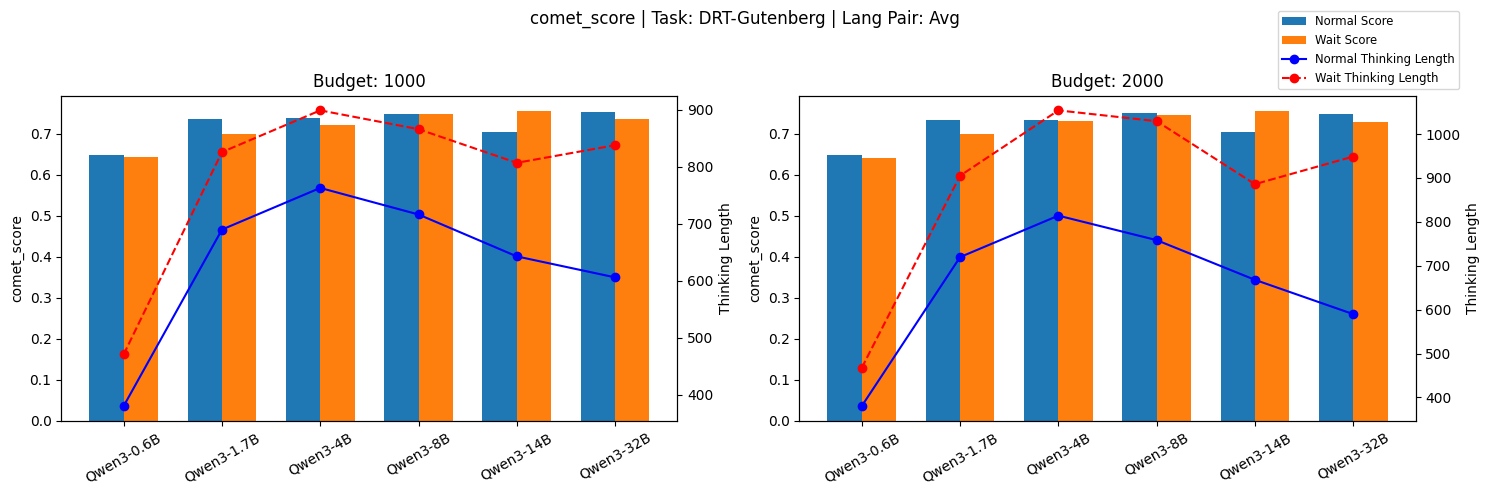

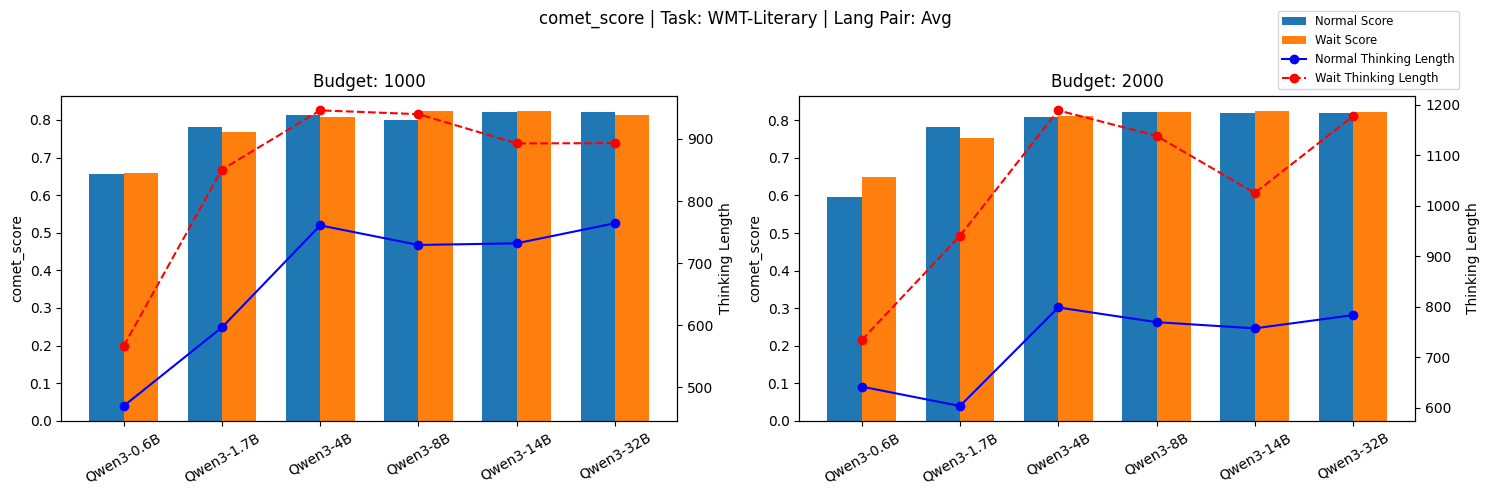

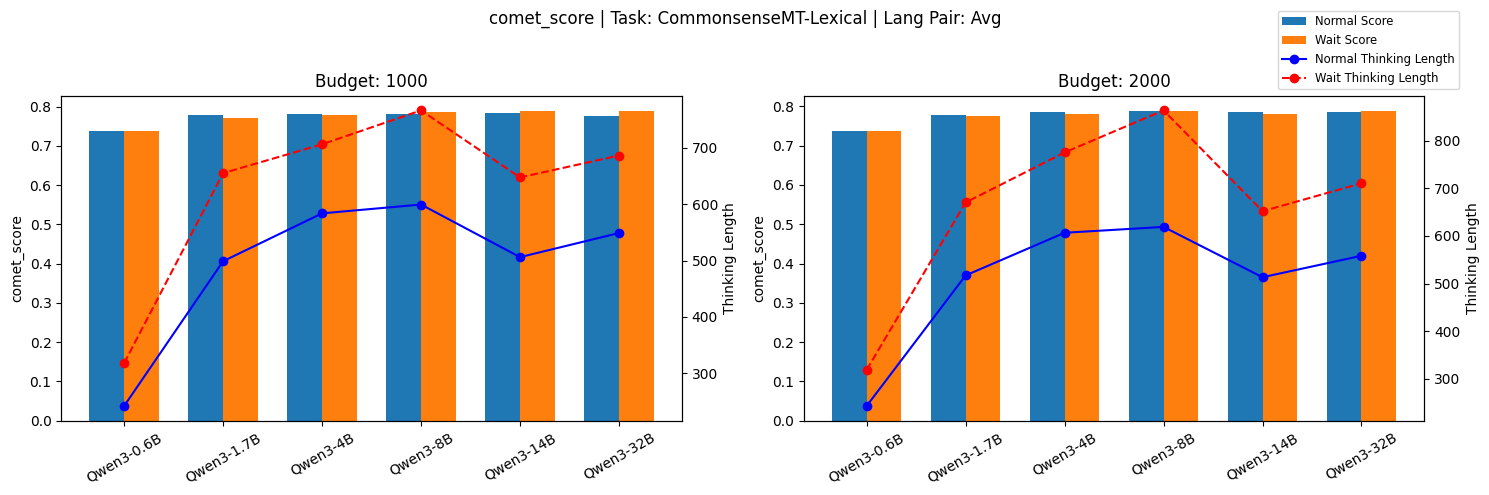

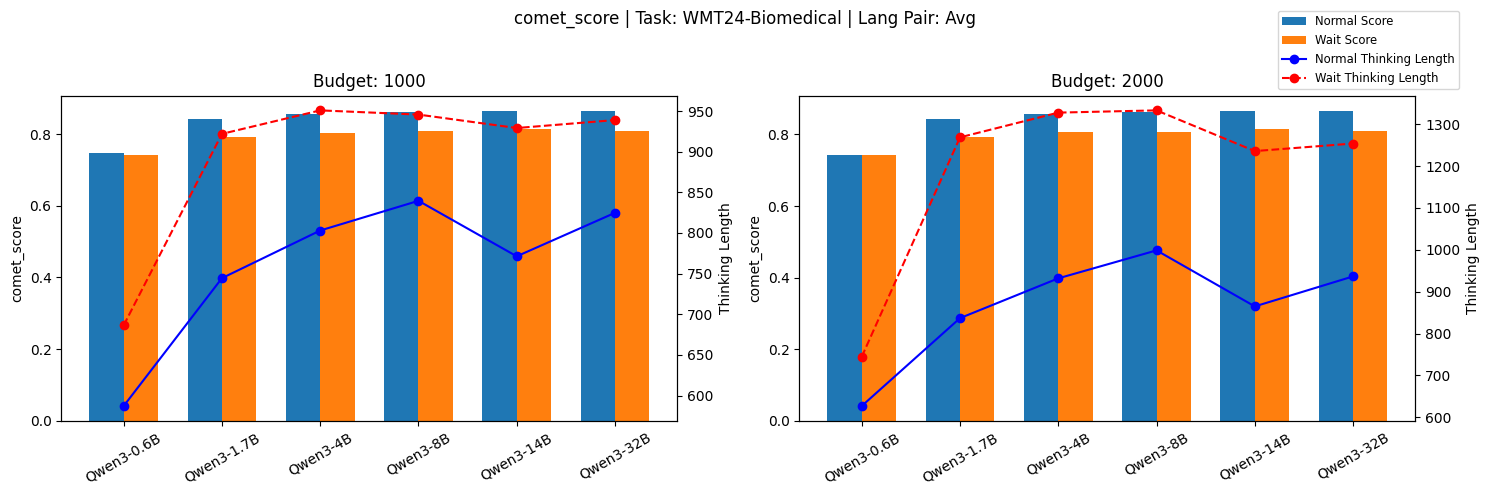

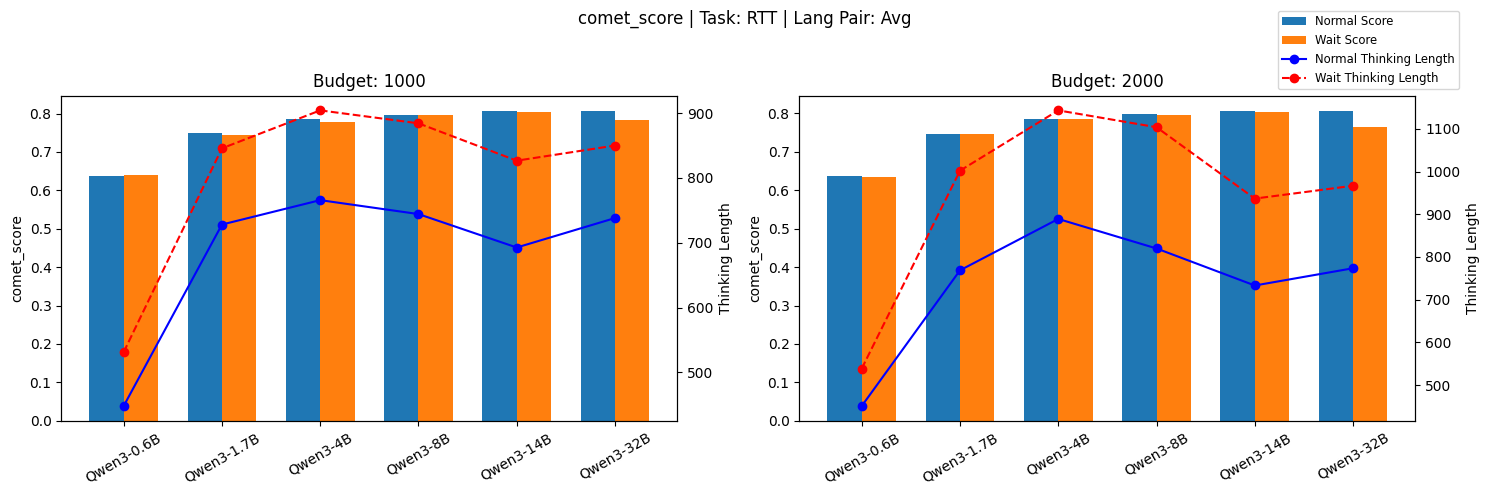

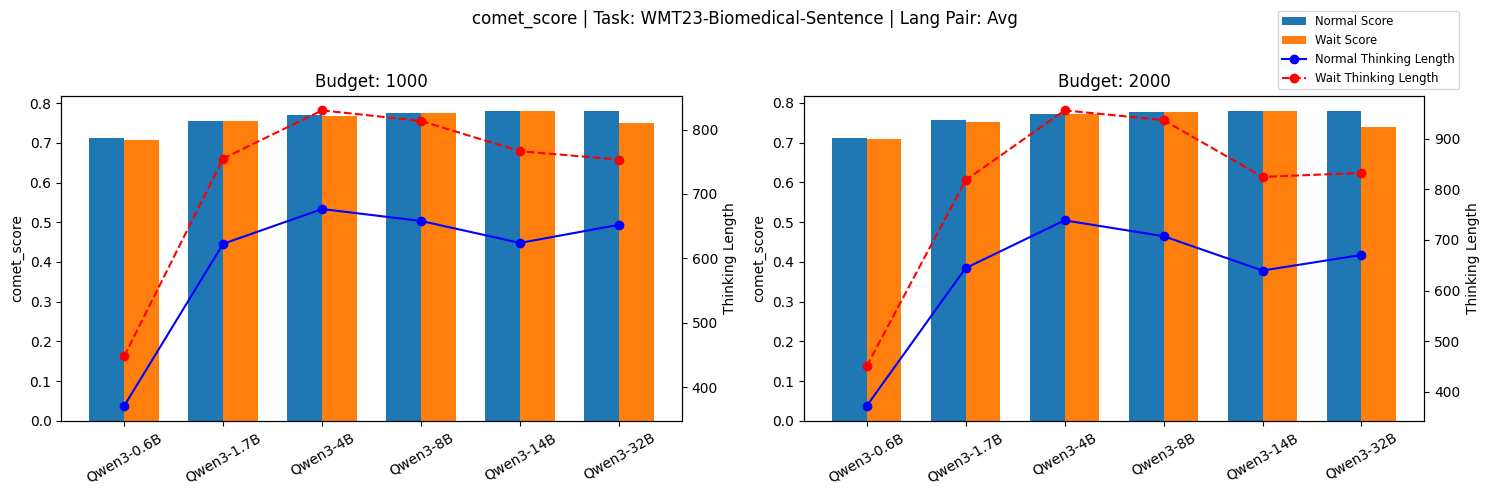

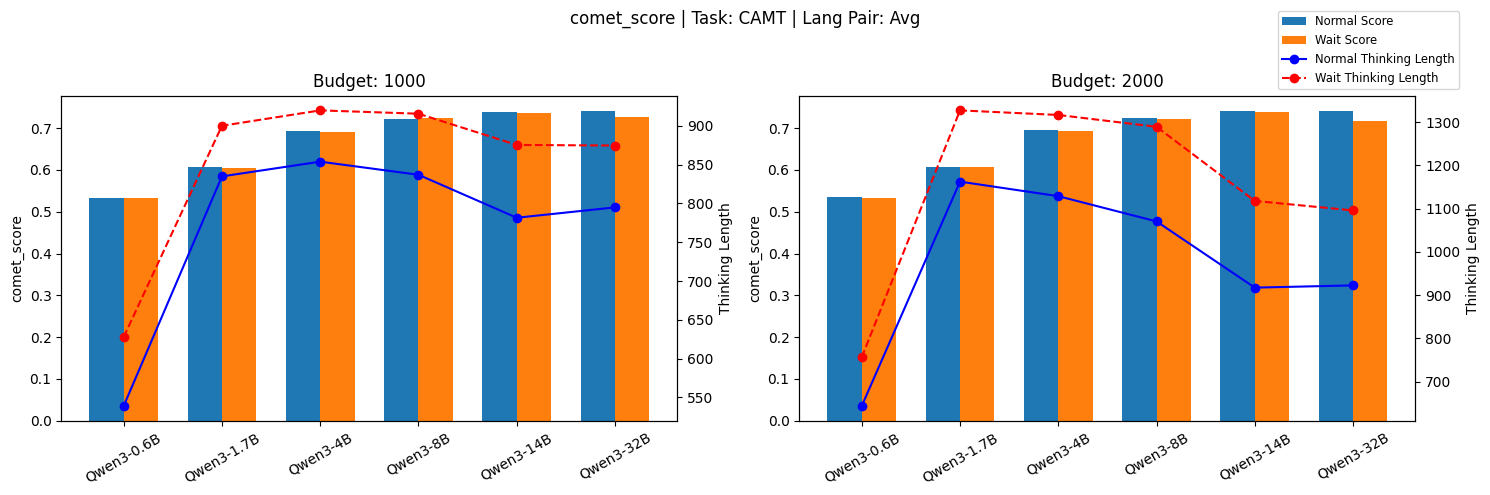

In [33]:
import matplotlib.pyplot as plt

metric = "comet_score"
thinking_metric = "thinking_length"
budgets = [1000, 2000]
merge_cols = ["model", "task", "lang_pair", "budget"]

# 取分数
df_score = dfs_by_metric[metric]
df_score_wait = dfs_by_metric_wait[metric]
df_score = df_score[df_score["budget"].isin(budgets)].rename(
    columns={"score": "score_normal"}
)
df_score_wait = df_score_wait[df_score_wait["budget"].isin(budgets)].rename(
    columns={"score": "score_wait"}
)

# 取思考长度
df_thinking = dfs_by_metric[thinking_metric]
df_thinking_wait = dfs_by_metric_wait[thinking_metric]
df_thinking = df_thinking[df_thinking["budget"].isin(budgets)].rename(
    columns={"score": "think_normal"}
)
df_thinking_wait = df_thinking_wait[df_thinking_wait["budget"].isin(budgets)].rename(
    columns={"score": "think_wait"}
)

# 合并
df_merged = pd.merge(
    df_score, df_score_wait[merge_cols + ["score_wait"]], on=merge_cols, how="inner"
)
df_merged = pd.merge(
    df_merged, df_thinking[merge_cols + ["think_normal"]], on=merge_cols, how="left"
)
df_merged = pd.merge(
    df_merged, df_thinking_wait[merge_cols + ["think_wait"]], on=merge_cols, how="left"
)

tasks = df_merged["task"].unique()
for task in tasks:
    task_df = df_merged[(df_merged["task"] == task) & (df_merged["lang_pair"] == "Avg")]
    if task_df.empty:
        continue

    fig, axes = plt.subplots(1, len(budgets), figsize=(15, 5), sharey=False)
    if len(budgets) == 1:
        axes = [axes]

    all_handles = []
    all_labels = []

    for idx, budget in enumerate(budgets):
        plot_df = task_df[task_df["budget"] == budget]
        if plot_df.empty:
            continue

        plot_df = plot_df.copy()
        plot_df['model_size'] = plot_df['model'].map(get_model_size)
        plot_df = plot_df.sort_values('model_size')

        ax1 = axes[idx]
        x = range(len(plot_df))
        models = plot_df["model"]

        width = 0.35
        bars1 = ax1.bar(
            [i - width / 2 for i in x],
            plot_df["score_normal"],
            width=width,
            label="Normal Score",
        )
        bars2 = ax1.bar(
            [i + width / 2 for i in x],
            plot_df["score_wait"],
            width=width,
            label="Wait Score",
        )
        ax1.set_ylabel(f"{metric}")
        # ax1.set_xlabel("Model")
        ax1.set_xticks(x)
        ax1.set_xticklabels(models, rotation=30)
        ax1.set_title(f"Budget: {budget}")

        # 右侧y轴：thinking_length
        ax2 = ax1.twinx()
        (line1,) = ax2.plot(
            x,
            plot_df["think_normal"],
            marker="o",
            linestyle="-",
            color="blue",
            label="Normal Thinking Length",
        )
        (line2,) = ax2.plot(
            x,
            plot_df["think_wait"],
            marker="o",
            linestyle="--",
            color="red",
            label="Wait Thinking Length",
        )
        ax2.set_ylabel("Thinking Length")

        # 收集legend handles和labels
        handles1, labels1 = ax1.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        all_handles += handles1 + handles2
        all_labels += labels1 + labels2

    # 去重，保持顺序
    unique = dict(zip(all_labels, all_handles))
    fig.legend(
        list(unique.values()),
        list(unique.keys()),
        loc="upper right",
        bbox_to_anchor=(0.98, 0.99),
        fontsize="small",
        frameon=True,
        ncol=1,
    )

    plt.suptitle(f"{metric} | Task: {task} | Lang Pair: Avg")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()